In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft

In [48]:
df = pd.read_csv(r"C:\Users\admin\Documents\Algo Asylum\Precipitation_Analysis\preci_all.csv")
df.columns = ['Date','ddate','value','geo']
df['Date'] = df['Date'].astype(str).str[:-2].astype(str)
df['Date'].iloc[43]
df.columns
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d%H%M')
del df['ddate'],df['geo']
#plt.show()

Text(0.5, 1.0, 'Data')

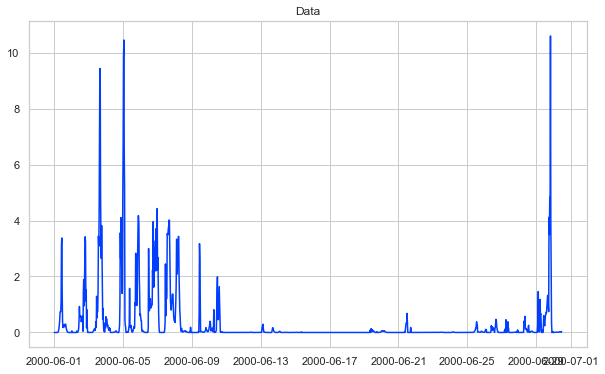

In [49]:
sd = df.loc[(df['Date'].between('2000-06-01 00:00:00', '2000-06-30 11:30:00', inclusive=True))]
#sd['Date'] = pd.to_datetime(sd['Date'])
#y['date'] = y.groupby(y['date'].dt.date).sum()
#sd = sd.iloc[:, 1:]
y = sd['value']
x = sd['Date']
plt.figure(figsize=(10,6))
plt.plot(sd['Date'], sd['value'])
plt.title("Data")

In [50]:
sd

,Date,value
0,2000-06-01 00:00:00,0.000000
1,2000-06-01 00:30:00,0.000000
2,2000-06-01 01:00:00,0.000000
3,2000-06-01 01:30:00,0.000000
4,2000-06-01 02:00:00,0.000000
...,...,...
1411,2000-06-30 09:30:00,0.026995
1412,2000-06-30 10:00:00,0.023328
1413,2000-06-30 10:30:00,0.017307
1414,2000-06-30 11:00:00,0.034393


In [51]:
x = np.arange(0, 1416, 1)
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# GMM on actual time series

In [52]:
dfx = signal_3
lowest_bic = np.infty
bic = []
n_components_range = range(1, 100)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [53]:
print(best_gmm, '\n')
print('WEIGHTS -', best_gmm.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=16) 

WEIGHTS - [0.0672071  0.03073547 0.02852673 0.02357116 0.03256537 0.00705947
 0.05860196 0.05175505 0.02205866 0.03208394 0.18709688 0.32292423
 0.0480993  0.04604678 0.02308889 0.01857901] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[3.39760593e+02 3.00693643e-02]
 [1.17156830e+03 1.02068965e-02]
 [2.99251333e+02 3.06941364e+00]
 [9.03987923e+02 4.00730943e-02]
 [1.36938696e+03 1.73541778e-02]
 [9.84013007e+02 2.52688860e-01]
 [2.75610664e+02 1.04816674e+00]
 [1.10522240e+02 2.80213618e-01]
 [5.11783280e+02 4.53772309e-03]
 [4.10537401e+02 1.62363504e-01]
 [1.10534384e+03 1.94875618e-04]
 [6.83852150e+02 1.87865265e-04]
 [1.25532465e+03 1.73950365e-01]
 [9.11816686e+01 8.95959615e-04]
 [1.39778588e+02 4.18389463e+00]
 [1.37217978e+03 1.86995720e+00]] 



<AxesSubplot:title={'center':'Values given by GMM'}>

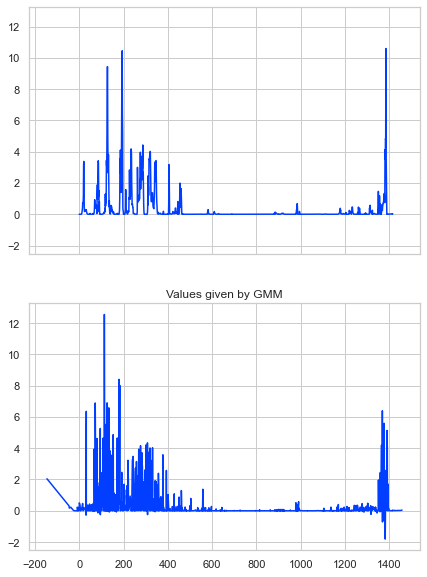

In [54]:
fig, ax = plt.subplots(2, sharex='all', sharey='all', figsize=(7,10))
z,_ = best_gmm.sample(1416)
plt.title('Actual data')
ax[0].plot(signal_3['Time'], signal_3['Value'])
plt.title('Values given by GMM')
sns.lineplot(z[:,0],z[:,1])

# GMM on abs FFT

In [55]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data = pd.DataFrame(zip(np.abs(f[:N//2+1]),np.abs(yf[:N//2+1])),columns=['Freq','Ampli'])
    return fft_data

In [56]:
freq_ampli = freq(signal_3)

<AxesSubplot:xlabel='Freq', ylabel='Ampli'>

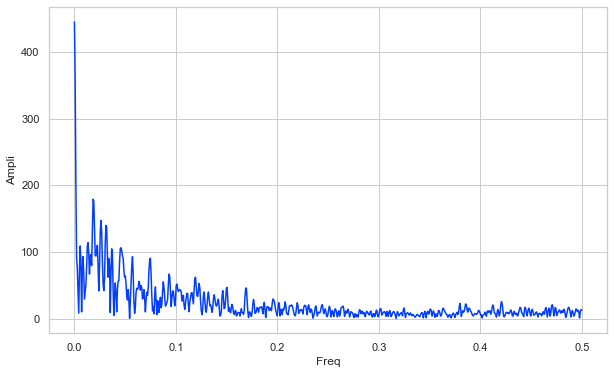

In [57]:
plt.figure(figsize=(10,6))
sns.lineplot(freq_ampli['Freq'], freq_ampli['Ampli'])

In [58]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 100)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm
best_gmm1 = GMM_fit(freq_ampli)

In [59]:
print(best_gmm1, '\n')
print('WEIGHTS -', best_gmm1.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm1.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=6) 

WEIGHTS - [0.61529981 0.06041497 0.00282345 0.16258638 0.02721271 0.13166268] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[3.38658726e-01 8.96176905e+00]
 [3.45293060e-02 8.13679347e+01]
 [3.54074112e-04 4.00981364e+02]
 [9.33078269e-02 3.71481898e+01]
 [1.96829164e-02 1.22288740e+02]
 [1.80993245e-01 1.75410032e+01]] 



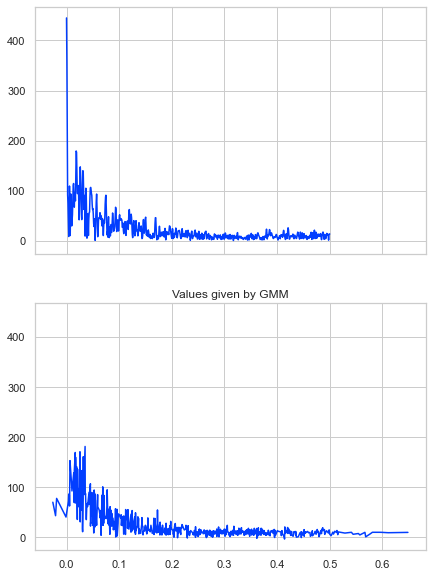

In [60]:
fig, ax = plt.subplots(2, sharex='all', sharey='all', figsize=(7,10))
z2,_ = best_gmm1.sample(708)
plt.title('Actual data')
ax[0].plot(freq_ampli['Freq'], freq_ampli['Ampli'])
#plt.show()
plt.title('Values given by GMM')
sns.lineplot(z2[:,0],z2[:,1])
plt.show()

# GMM on FFT of actual time series

In [61]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_real,freq_ampli_img
freq_ampli3,freq_ampli3i = freq(signal_3)

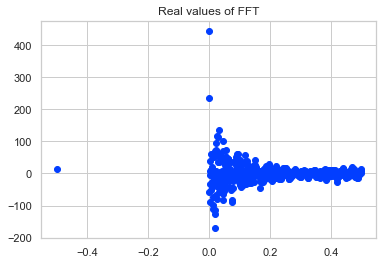

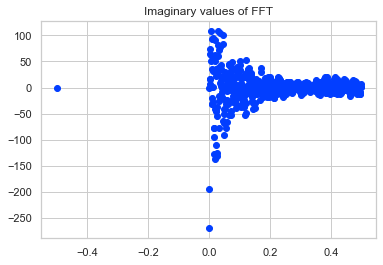

In [82]:
plt.scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
plt.title('Real values of FFT')
plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

In [63]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 100)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [64]:
best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      # GMM on imaginary part of FFT data

In [65]:
#Sampling
z1,_ = best_gmm0.sample(708)
z1i,_ = best_gmm0i.sample(708)

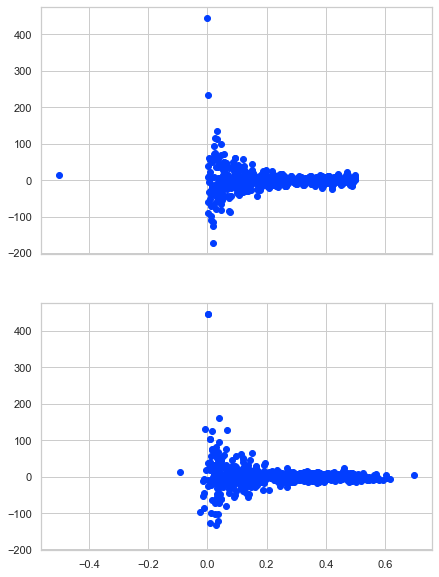

In [84]:
fig, ax = plt.subplots(2, sharex='all', sharey='all', figsize=(7,10))
ax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
ax[1].scatter(z1[:, 0], z1[:, 1])
plt.show()

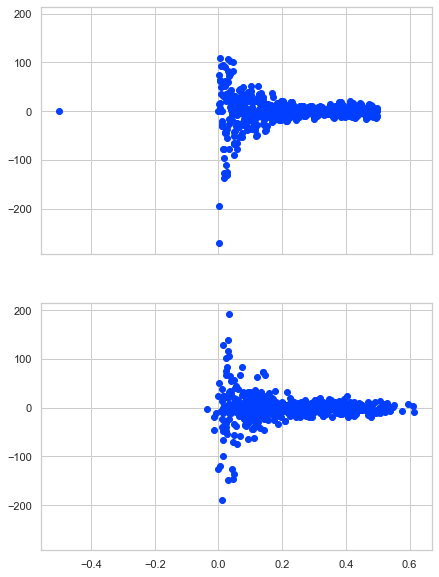

In [85]:
fig, ax = plt.subplots(2, sharex='all', sharey='all', figsize=(7,10))
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [68]:
print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=4) 

WEIGHTS - [0.69742386 0.19903169 0.10213401 0.00141044] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 3.19219536e-01  1.21214108e-02]
 [ 1.13990569e-01  2.89248156e-01]
 [ 3.20217110e-02 -3.62796011e+00]
 [ 0.00000000e+00  4.45011489e+02]] 



In [69]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=3) 

WEIGHTS - [0.71064064 0.09102223 0.19833713] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 0.31682975 -0.18464403]
 [ 0.02716214 -4.95024476]
 [ 0.1057044   1.08924568]] 



In [70]:
sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [71]:
sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [72]:
#sample_1 = sample_1[(sample_1.Ampli>1) | (sample_1.Ampli<-1)]
#sample_1i = sample_1i[(sample_1i.Ampli>1) | (sample_1i.Ampli<-1)]

In [73]:
f = fftpack.fftfreq(1416)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [74]:
sd = dict(zip(np.round(f,4),np.zeros(len(f))))

In [75]:
sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,4))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,4))

In [76]:
samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [77]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.0001 in sd:
        sd[i+0.0001] = samp_1[i]
        sd[-(i+0.0001)] = samp_1[i]
    elif i-0.0001 in sd:
        sd[i-0.0001] = samp_1[i]
        sd[-(i-0.0001)] = samp_1[i]
sd

{0.0: 0.0,
 0.0007: 0.0,
 0.0014: 445.010945914001,
 0.0021: 0.0,
 0.0028: 0.0,
 0.0035: 0.0,
 0.0042: 0.0,
 0.0049: 0.0,
 0.0056: 0.0,
 0.0064: 0.0,
 0.0071: 0.0,
 0.0078: 0.0,
 0.0085: 38.89742278812933,
 0.0092: -126.04449758495664,
 0.0099: 0.0,
 0.0106: 0.0,
 0.0113: 0.0,
 0.012: -99.71687228233198,
 0.0127: 0.0,
 0.0134: 57.83845769628755,
 0.0141: 0.0,
 0.0148: 124.46626626934446,
 0.0155: 0.0,
 0.0162: 75.76160254145913,
 0.0169: 74.05606014213957,
 0.0177: 0.0,
 0.0184: 0.0,
 0.0191: 0.0,
 0.0198: 0.0,
 0.0205: 0.0,
 0.0212: 0.0,
 0.0219: 0.0,
 0.0226: 6.059174753052523,
 0.0233: 66.80071004446623,
 0.024: 0.0,
 0.0247: 0.0,
 0.0254: 0.0,
 0.0261: 0.0,
 0.0268: 0.0,
 0.0275: 80.02563914465638,
 0.0282: 0.0,
 0.029: 18.34093999911604,
 0.0297: 23.98950027766849,
 0.0304: 0.0,
 0.0311: 0.0,
 0.0318: -17.74442890616828,
 0.0325: 0.0,
 0.0332: 54.5474110163368,
 0.0339: 0.0,
 0.0346: 0.0,
 0.0353: 4.018663302862417,
 0.036: 0.0,
 0.0367: 0.0,
 0.0374: 0.0,
 0.0381: -72.03966387277

In [78]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.0001 in sd:
        sd[i+0.0001] = complex(sd[i+0.0001],samp_1i[i])
        sd[-(i+0.0001)] = complex(sd[i+0.0001],-(samp_1i[i]))
    elif i-0.0001 in sd:
        sd[i-0.0001] = complex(sd[i-0.0001],samp_1i[i])
        sd[-(i-0.0001)] = complex(sd[i-0.0001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.0007: 0.0,
 0.0014: 445.010945914001,
 0.0021: 0.0,
 0.0028: 0.0,
 0.0035: 0.0,
 0.0042: 0.0,
 0.0049: 0.0,
 0.0056: 0.0,
 0.0064: 0.0,
 0.0071: 0.0,
 0.0078: 0.0,
 0.0085: 38.89742278812933,
 0.0092: -126.04449758495664,
 0.0099: 0.0,
 0.0106: 0.0,
 0.0113: -39.99882572962828j,
 0.012: (-99.71687228233198+37.41214740611018j),
 0.0127: 0.0,
 0.0134: 57.83845769628755,
 0.0141: -58.05417998676333j,
 0.0148: 124.46626626934446,
 0.0155: 0.0,
 0.0162: (75.76160254145913+1.8540934931296311j),
 0.0169: 74.05606014213957,
 0.0177: 0.0,
 0.0184: 0.0,
 0.0191: 0.0,
 0.0198: 0.0,
 0.0205: 0.0,
 0.0212: 0.0,
 0.0219: 0.0,
 0.0226: (6.059174753052523+62.31876437274318j),
 0.0233: (66.80071004446623-31.17669435445385j),
 0.024: 66.65085052936843j,
 0.0247: 0.0,
 0.0254: 0.0,
 0.0261: 0.0,
 0.0268: -54.54510679600084j,
 0.0275: (80.02563914465638+24.114974510268617j),
 0.0282: 0.0,
 0.029: (18.34093999911604+6.212671704914463j),
 0.0297: 23.98950027766849,
 0.0304: -2.005324599443089j

In [79]:
value = list(sd.values())

# Final IFFT 

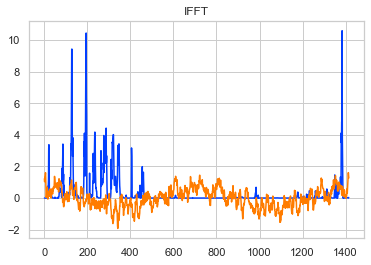

In [80]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(signal_3['Time'], signal_3['Value'])
plt.plot(x,ift)